### Semi-supervised learning
## Multi-tasking 
Data taken from https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download'

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import glob

        
def visualize_slices(input_batch, target_batch, recon_batch, seg_batch, slice_idx=24):
    """
    Plots a 2D slice from the middle of a 4-tensor batch.
    """
    # Use torch.no_grad() to stop tracking gradients
    with torch.no_grad():
        
        # --- 1. Process Tensors ---
        
        # Move to CPU and convert to NumPy
        # Squeeze out the channel dim (C=1)
        input_slice = input_batch.to('cpu').numpy()[0, 0, slice_idx, :, :]
        
        # Target is [B, D, H, W], no channel
        target_slice = target_batch.to('cpu').numpy()[0, slice_idx, :, :]
        
        # Recon needs detach() because it has grads
        recon_slice = recon_batch.to('cpu').detach().numpy()[0, 0, slice_idx, :, :]
        
        # Seg is the trickiest: [B, C, D, H, W]
        # We need to find the most likely class for each pixel (argmax)
        seg_logits = seg_batch.to('cpu').detach()
        seg_pred = torch.argmax(seg_logits, dim=1) # Shape: [B, D, H, W]
        seg_slice = seg_pred.numpy()[0, slice_idx, :, :]

        
        # --- 2. Plotting ---
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Plot 1: Original Input
        axes[0].imshow(input_slice, cmap='gray')
        axes[0].set_title(f"Input Image (Slice {slice_idx})")
        axes[0].axis('off')
        
        # Plot 2: Ground Truth Segmentation
        axes[1].imshow(target_slice, cmap='viridis', vmin=0, vmax=NUM_CLASSES-1)
        axes[1].set_title("Target Segmentation")
        axes[1].axis('off')
        
        # Plot 3: Reconstructed Output
        axes[2].imshow(recon_slice, cmap='gray')
        axes[2].set_title("Reconstructed Image")
        axes[2].axis('off')
        
        # Plot 4: Predicted Segmentation
        axes[3].imshow(seg_slice, cmap='viridis', vmin=0, vmax=NUM_CLASSES-1)
        axes[3].set_title("Predicted Segmentation")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()

In [43]:


INPUT_SHAPE = (1, 28, 28, 28) # (C, D, H, W)
NUM_CLASSES = 3  # Background, Segment 1, Segment 2
LATENT_DIM = 256 # RNN batch
BATCH_SIZE = 4
TIME_STEPS = 10 # Time series size 


class ConvBlock(nn.Module):
    """
    A 3D Convolutional block: Conv3D -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Seg_decoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.up_seg1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # -> 64x14x14x14
        self.dec_seg1 = ConvBlock(128, 64) # add skip connection 64+64= 128
        
        self.up_seg2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # 32x28x28x28
        self.dec_seg2 = ConvBlock(64, 32) # add skip connection 32+32= 64
        
        self.out_seg = nn.Conv3d(32, num_classes, kernel_size=1) # Output segmentation
        
    def forward(self, b , s1, s2):
         # segmentation decoder forward step
        us1 = self.up_seg1(b) # -> Bx64x14x14x14
        ds1 = self.dec_seg1(torch.cat([us1, s2], dim=1)) # Concat skip 2
        
        us2 = self.up_seg2(ds1) # -> Bx32x28x28x28
        ds2 = self.dec_seg2(torch.cat([us2, s1], dim=1)) # Concat skip 1
        us3 = self.out_seg(ds2) 
        return us3
    
class Recon_decoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.up_recon1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # ->64x14x14x14
        self.dec_recon1 = ConvBlock(64, 64)

        self.up_recon2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # -> 32x28x28x28
        self.dec_recon2 = ConvBlock(32, 32)

        self.out_recon = nn.Sequential(
            nn.Conv3d(32, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, b):
        ur1 = self.up_recon1(b)   # -> Bx64x14x14x14
        dr1 = self.dec_recon1(ur1)
        
        ur2 = self.up_recon2(dr1) # -> Bx3x28x28x28
        dr2 = self.dec_recon2(ur2)

        ur3 = self.out_recon(dr2) # -> Bx1x28x28x28

        return ur3

In [44]:

class MultiTaskNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, latent_dim=256):
        super().__init__()
        
        # Commen encoder
        # 1x28x28x28
        self.enc1 = ConvBlock(in_channels, 32) # -> 32x28x28x28
        self.pool1 = nn.MaxPool3d(2) # -> 32x14x14x14
        
        self.enc2 = ConvBlock(32, 64) # -> 64x14x14x14
        self.pool2 = nn.MaxPool3d(2) # -> 64x7x7x7
        
        # Bottleneck 
        self.bottleneck = ConvBlock(64, 128) # -> 128x7x7x7
        
        # Feature vector for rnn input
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.to_latent_vec = nn.Linear(128, latent_dim) # -> Bx256x

        # First decoder head for segmentation with skipped connect
        self.seg_decoder = Seg_decoder(num_classes=num_classes)

        # Second decoder head reconstruction without skipped
        self.recon_decoder = Recon_decoder(in_channels=in_channels)
        

    def forward(self, x):
        # commen encoder
        s1 = self.enc1(x)       # -> Bx32x28x28x28]
        p1 = self.pool1(s1)     # -> Bx32x14x14x14
        
        s2 = self.enc2(p1)      # -> Bx64x14x14x14
        p2 = self.pool2(s2)     # -> Bx64x7x7x7x
        
        # bottleneck -> could be variational
        b = self.bottleneck(p2) # [B, 128, 7, 7, 7]

        # Vectorize bottleneck output 
        pooled_vec = self.global_pool(b).view(b.size(0), -1) # -<Bx128
        latent_z = self.to_latent_vec(pooled_vec)            # ->Bx256

        # Segmentation decoder head with skips
        seg_output = self.seg_decoder(b, s1, s2)

        # Reconstruction decoder head without skips
        recon_output = self.recon_decoder(b)
        
        return seg_output, recon_output, latent_z


# Temporal model -> could add more dimension 
class TemporalTracker(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True 
        )

        # predict t+1
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, z_sequence):
        # z_sequence shape -> Batch x Time_Steps x latent_dim
        lstm_out, _ = self.lstm(z_sequence)
        
        # only care about t+1
        last_step_out = lstm_out[:, -1, :] # -1 last time step +1 
        
        # fc layer for prediction
        prediction = self.fc(last_step_out)
        return prediction


In [45]:
class LiverDataset(Dataset):
    """
    Custom PyTorch Dataset for the 3D Liver Segmentation data.
    """
    def __init__(self, image_dir, label_dir, target_size=(28, 28, 28)):
        
        # --- THIS IS THE CORRECTED PART (looking for .nii) ---
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "*.nii")))
        # --- END OF CORRECTION ---
        
        self.target_size = target_size # (D, H, W)
        
        # Ensure we have matched pairs
        assert len(self.image_paths) > 0, f"No images found in {image_dir}"
        assert len(self.label_paths) > 0, f"No labels found in {label_dir}"
        assert len(self.image_paths) == len(self.label_paths), \
            f"Found {len(self.image_paths)} images but {len(self.label_paths)} labels."
        
        print(f"Found {len(self.image_paths)} image/label pairs.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI files (nibabel handles .nii and .nii.gz the same way)
        img_nii = nib.load(self.image_paths[idx])
        lbl_nii = nib.load(self.label_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)
        lbl_tensor = torch.from_numpy(lbl_nii.get_fdata()).long().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        lbl_resized = F.interpolate(lbl_tensor.float().unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='nearest').squeeze(0).long()

        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # Squeeze the channel dim from the label
        lbl_resized = lbl_resized.squeeze(0) 

        return img_resized, lbl_resized

In [46]:
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- THIS IS THE CORRECTED PART ---
    
# 1. Setup DataLoaders
DATA_DIR = "./Task03_Liver_rs" 
image_folder = os.path.join(DATA_DIR, 'imagesTr')
label_folder = os.path.join(DATA_DIR, 'labelsTr')

print(image_folder)


Using device: cpu
./Task03_Liver_rs/imagesTr


In [47]:

try:
    full_dataset = LiverDataset(image_dir=image_folder, label_dir=label_folder)
    
    data_loader = DataLoader(
        dataset=full_dataset,
        batch_size=BATCH_SIZE, # BATCH_SIZE defined at top of file
        shuffle=True
        )
except Exception as e:
    print(f"Error creating dataset: {e}")
    print("Please double-check your file paths.")
    exit()

Found 123 image/label pairs.


--- Training the MultiTaskNet on Liver Data ---

--- Epoch 1/20 ---
Batch 0/31 | Total Loss: 1.2258 | Seg Loss: 1.1757 | Recon Loss: 0.1002
--- Visualizing first training batch ---


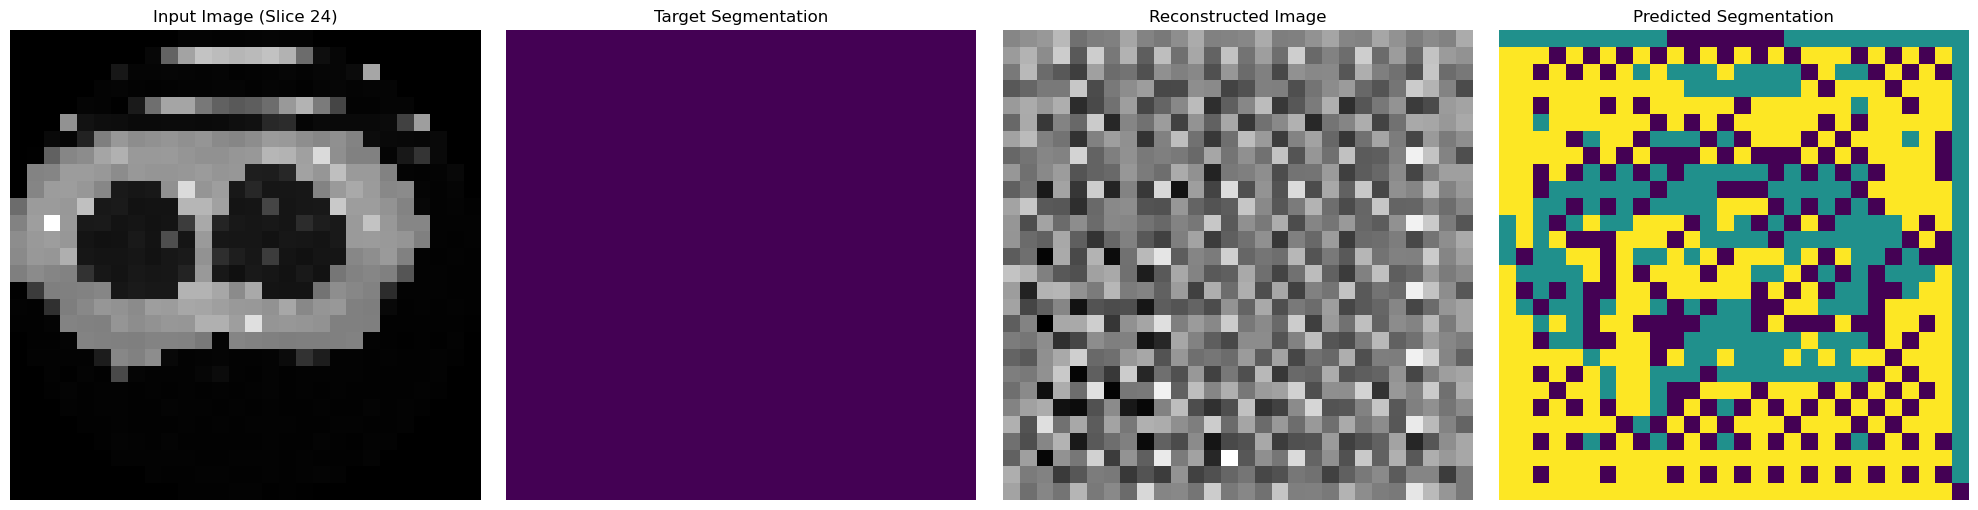

Batch 30/31 | Total Loss: 0.4859 | Seg Loss: 0.4768 | Recon Loss: 0.0182
--- Visualizing first training batch ---


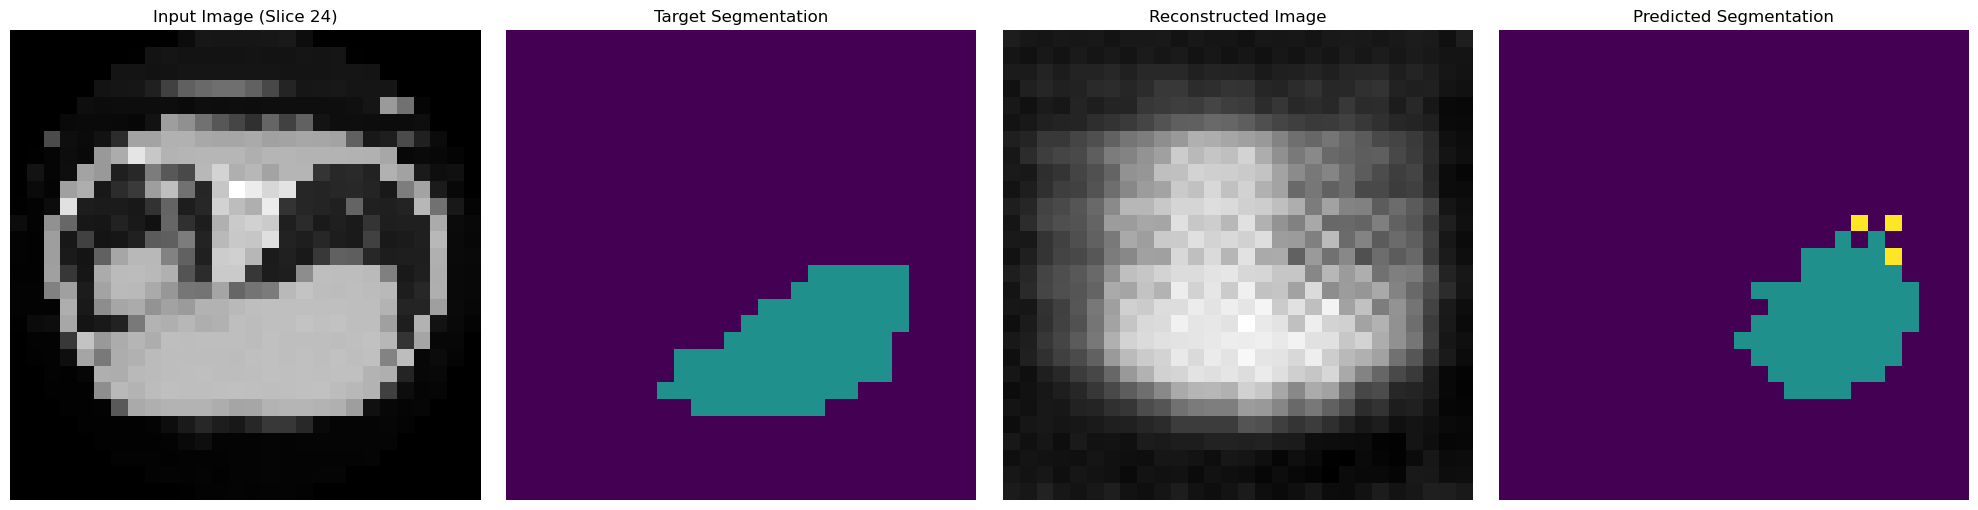


--- Epoch 2/20 ---
Batch 0/31 | Total Loss: 0.5160 | Seg Loss: 0.5056 | Recon Loss: 0.0209
Batch 30/31 | Total Loss: 0.3068 | Seg Loss: 0.3007 | Recon Loss: 0.0122

--- Epoch 3/20 ---
Batch 0/31 | Total Loss: 0.2811 | Seg Loss: 0.2755 | Recon Loss: 0.0114
Batch 30/31 | Total Loss: 0.1808 | Seg Loss: 0.1726 | Recon Loss: 0.0164

--- Epoch 4/20 ---
Batch 0/31 | Total Loss: 0.1896 | Seg Loss: 0.1846 | Recon Loss: 0.0101
Batch 30/31 | Total Loss: 0.1216 | Seg Loss: 0.1159 | Recon Loss: 0.0113

--- Epoch 5/20 ---
Batch 0/31 | Total Loss: 0.1786 | Seg Loss: 0.1698 | Recon Loss: 0.0176
Batch 30/31 | Total Loss: 0.0894 | Seg Loss: 0.0855 | Recon Loss: 0.0078

--- Epoch 6/20 ---
Batch 0/31 | Total Loss: 0.0923 | Seg Loss: 0.0888 | Recon Loss: 0.0069
Batch 30/31 | Total Loss: 0.0852 | Seg Loss: 0.0805 | Recon Loss: 0.0093

--- Epoch 7/20 ---
Batch 0/31 | Total Loss: 0.0814 | Seg Loss: 0.0788 | Recon Loss: 0.0054
Batch 30/31 | Total Loss: 0.0616 | Seg Loss: 0.0579 | Recon Loss: 0.0073

--- Epoch

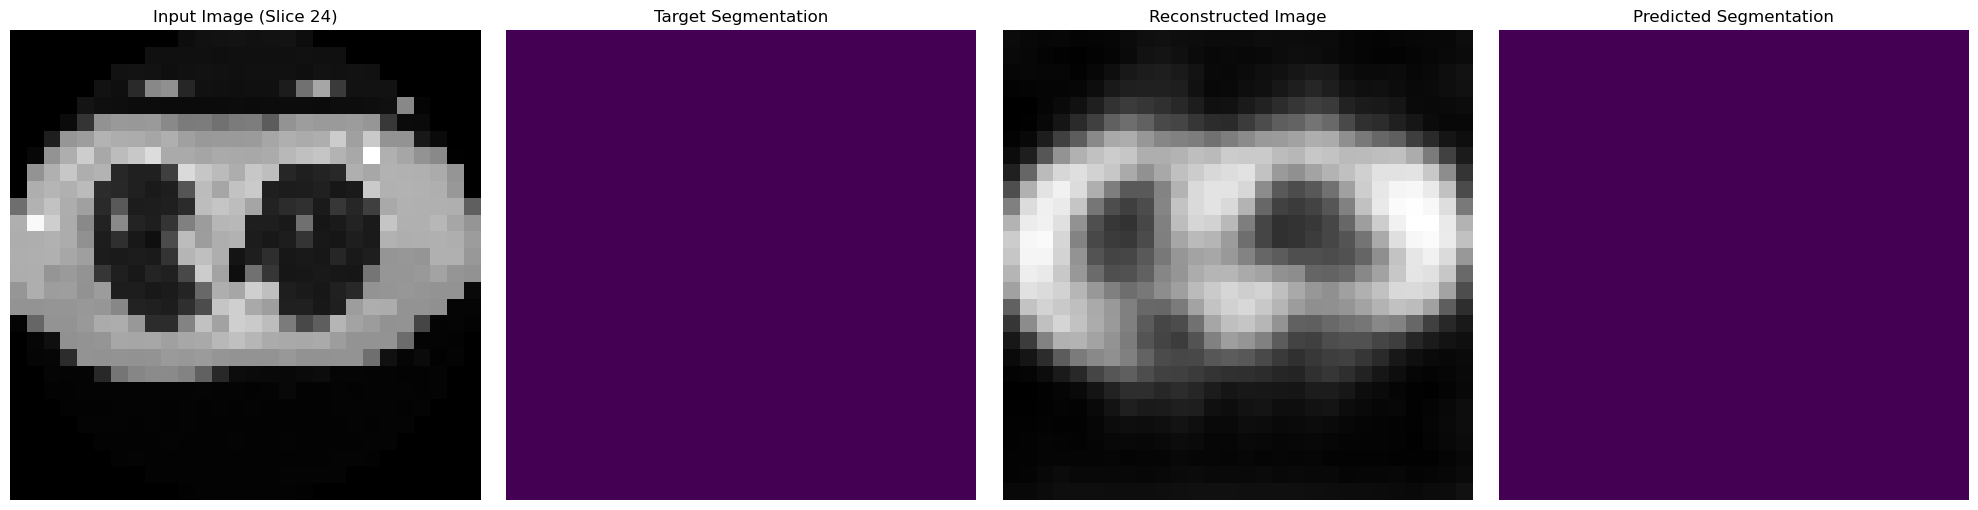

Batch 30/31 | Total Loss: 0.0480 | Seg Loss: 0.0446 | Recon Loss: 0.0067
--- Visualizing first training batch ---


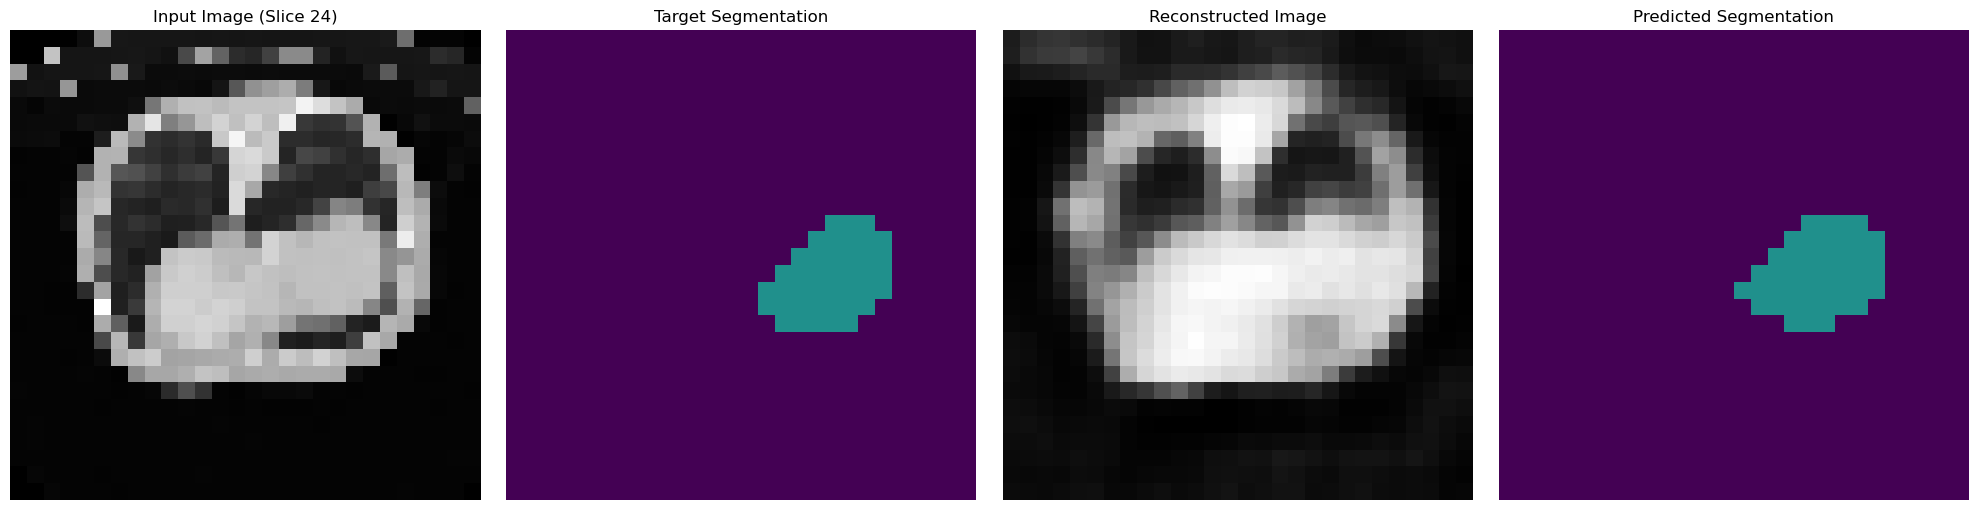


--- Epoch 12/20 ---
Batch 0/31 | Total Loss: 0.0362 | Seg Loss: 0.0331 | Recon Loss: 0.0063
Batch 30/31 | Total Loss: 0.0357 | Seg Loss: 0.0327 | Recon Loss: 0.0059

--- Epoch 13/20 ---
Batch 0/31 | Total Loss: 0.0333 | Seg Loss: 0.0308 | Recon Loss: 0.0050
Batch 30/31 | Total Loss: 0.0365 | Seg Loss: 0.0333 | Recon Loss: 0.0064

--- Epoch 14/20 ---
Batch 0/31 | Total Loss: 0.0312 | Seg Loss: 0.0283 | Recon Loss: 0.0058
Batch 30/31 | Total Loss: 0.0513 | Seg Loss: 0.0471 | Recon Loss: 0.0084

--- Epoch 15/20 ---
Batch 0/31 | Total Loss: 0.0336 | Seg Loss: 0.0307 | Recon Loss: 0.0058
Batch 30/31 | Total Loss: 0.0262 | Seg Loss: 0.0236 | Recon Loss: 0.0051

--- Epoch 16/20 ---
Batch 0/31 | Total Loss: 0.0386 | Seg Loss: 0.0359 | Recon Loss: 0.0054
Batch 30/31 | Total Loss: 0.0308 | Seg Loss: 0.0270 | Recon Loss: 0.0076

--- Epoch 17/20 ---
Batch 0/31 | Total Loss: 0.0258 | Seg Loss: 0.0228 | Recon Loss: 0.0060
Batch 30/31 | Total Loss: 0.0308 | Seg Loss: 0.0286 | Recon Loss: 0.0045

---

In [ ]:

if __name__ == "__main__":


    # 2. Instantiate the model
    model = MultiTaskNet(
        in_channels=1, 
        num_classes=NUM_CLASSES, # NUM_CLASSES defined at top
        latent_dim=LATENT_DIM  # LATENT_DIM defined at top
    ).to(device)

    # 3. Define Losses and Optimizers
    loss_fn_seg = nn.CrossEntropyLoss()
    loss_fn_recon = nn.MSELoss()
    optimizer_model = optim.Adam(model.parameters(), lr=1e-3)

    print("--- Training the MultiTaskNet on Liver Data ---")

    NUM_EPOCHS = 20
    
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
        model.train() 
        
        for batch_idx, (x_labeled, y_seg_target) in enumerate(data_loader):
            x_labeled = x_labeled.to(device)       
            y_seg_target = y_seg_target.to(device) 

            optimizer_model.zero_grad()
            
            seg_out, recon_out, _ = model(x_labeled)
            
            loss_seg = loss_fn_seg(seg_out, y_seg_target)
            loss_recon = loss_fn_recon(recon_out, x_labeled)
            total_loss = (loss_seg * 1.0) + (loss_recon * 0.5) 
            
            total_loss.backward()
            optimizer_model.step()
            
            if batch_idx % 30 == 0:
                print(f"Batch {batch_idx}/{len(data_loader)} | Total Loss: {total_loss.item():.4f} | Seg Loss: {loss_seg.item():.4f} | Recon Loss: {loss_recon.item():.4f}")

            if epoch % 10 == 0 and batch_idx % 30 == 0:
                print("--- Visualizing first training batch ---")
                visualize_slices(x_labeled, y_seg_target, recon_out, seg_out)



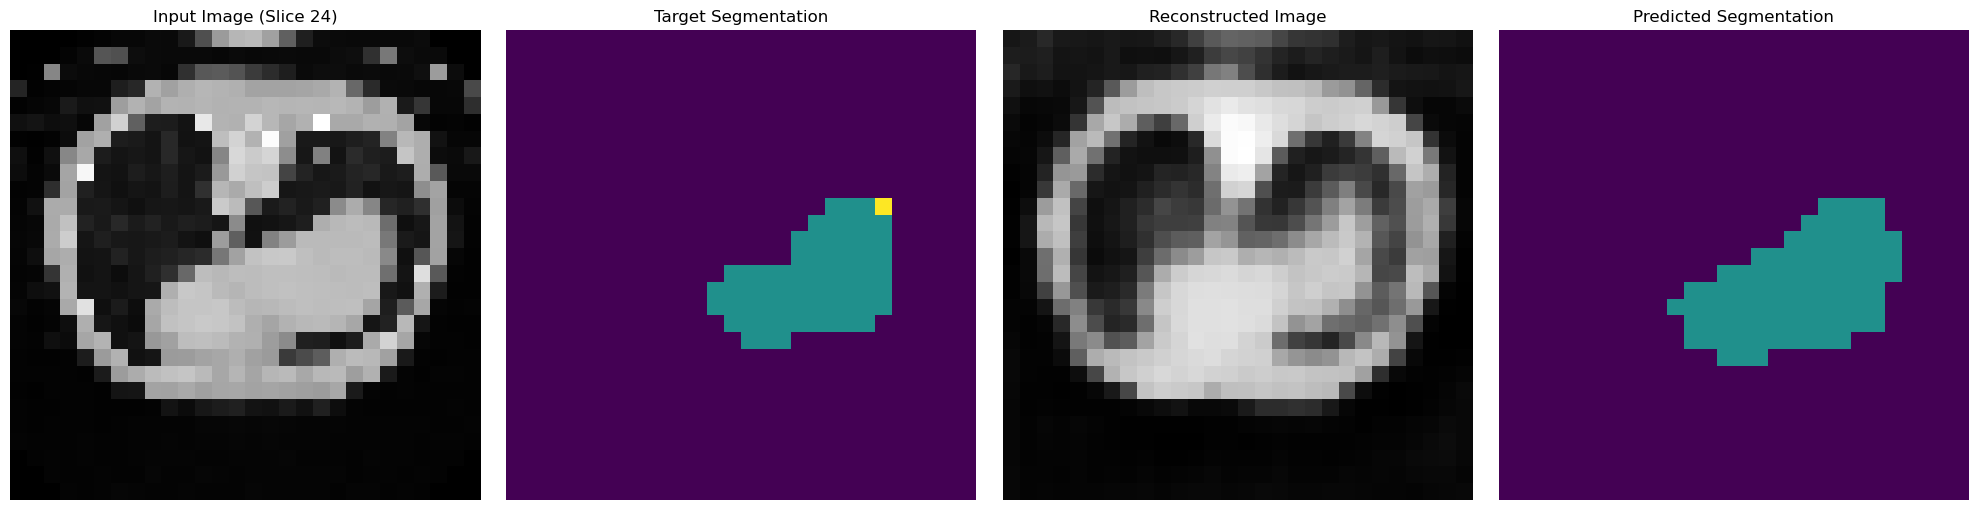

In [50]:
visualize_slices(x_labeled, y_seg_target, recon_out, seg_out)
